In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [53]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score
from sklearn import set_config


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [54]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

X = train.drop(['mineralType', 'id'], axis=1)

In [55]:
magma_ordinal_preprocessor = ColumnTransformer([
        ("temperatureFirstHalfPlanetRotation", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), StandardScaler()), ['temperatureFirstHalfPlanetRotation']),
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']),
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']),
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']),
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']),
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']),
        ("climaticZone", OrdinalEncoder(handle_unknown="error"), ['climaticZone']),
        ("geoZone", OneHotEncoder(handle_unknown = "error"), ['geoZone']),
        ("rockSize", OneHotEncoder(handle_unknown = "error", drop='first'), ['rockSize']),
        # ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']),
        ("magmaConcentrationDistance", OrdinalEncoder(categories=[['VERY_CLOSE', 'CLOSE', 'MEDIUM', 'FAR', 'VERY_FAR']], handle_unknown = "error"), ['magmaConcentrationDistance']),
        # ("mineralDensity", StandardScaler(), ['mineralDensity']), # imputar valor de -999.0
        # ("mineralDensity", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), StandardScaler()), ['mineralDensity']),
        ("mineralDensity", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), StandardScaler()), ['mineralDensity']),
        # ("detectionDepth", make_pipeline(FunctionTransformer(lambda f: f * 1000, feature_names_out="one-to-one"), StandardScaler()), ['detectionDepth']),
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", StandardScaler(), ['longitude']),
        # ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

preprocessor_robustScaler = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), RobustScaler()), ['temperatureFirstHalfPlanetRotation']),
        ("temperatureSecondHalfPlanetRotation", RobustScaler(), ['temperatureSecondHalfPlanetRotation']),
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), RobustScaler()), ['waterStreamDistanceX']),
        ("waterStreamDistanceY", RobustScaler(), ['waterStreamDistanceY']),
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']),
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']),
        ("climaticZone", OrdinalEncoder(handle_unknown="error"), ['climaticZone']),
        ("geoZone", OneHotEncoder(handle_unknown = "error"), ['geoZone']),
        ("rockSize", OneHotEncoder(handle_unknown = "error", drop='first'), ['rockSize']),
        # ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("magmaConcentrationDistance", OrdinalEncoder(categories=[['VERY_CLOSE', 'CLOSE', 'MEDIUM', 'FAR', 'VERY_FAR']], handle_unknown = "error"), ['magmaConcentrationDistance']),
        ("mineralDensity", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), RobustScaler()), ['mineralDensity']),
        ("detectionDepth", RobustScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", RobustScaler(), ['longitude']),
        # ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

In [56]:
pca_pipe = Pipeline([
    ('preprocessor', magma_ordinal_preprocessor),
    ('pca', PCA())
])

pca_pipe_robustScaler = Pipeline([
    ('preprocessor', preprocessor_robustScaler),
    ('pca', PCA())
])

In [57]:
pca_pipe.fit(X)

preprocessed_dataframe = pd.DataFrame(magma_ordinal_preprocessor.fit_transform(X), columns=pca_pipe['preprocessor'].get_feature_names_out())
modelo_pca = pca_pipe.named_steps['pca']
len(modelo_pca.components_)

23

In [58]:
# pd.DataFrame(
#     data    = modelo_pca.components_,
#     columns = pca_pipe['preprocessor'].get_feature_names_out(),
#     index   = [f'PC{i}' for i in range(len(modelo_pca.components_))]
# ).head()

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[4.39919234e-01 1.43037553e-01 1.21578193e-01 6.78749866e-02
 4.77877196e-02 3.54226452e-02 3.35955598e-02 2.53413159e-02
 2.15572273e-02 1.73489837e-02 1.47147858e-02 1.25748864e-02
 6.60641680e-03 4.64210445e-03 3.47899793e-03 3.30958190e-03
 9.59585889e-04 2.43003237e-04 7.21956373e-06 8.45402936e-34
 3.39480849e-34 1.39948349e-34 4.74430550e-35]


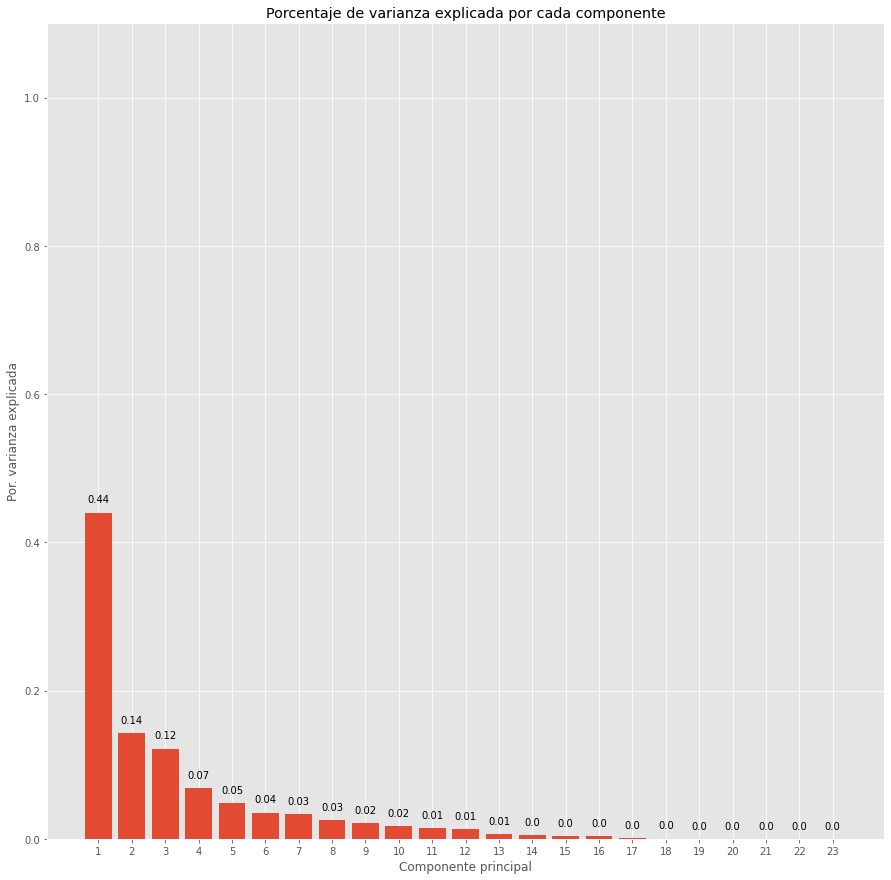

In [59]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(preprocessed_dataframe.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.43991923 0.58295679 0.70453498 0.77240997 0.82019769 0.85562033
 0.88921589 0.91455721 0.93611443 0.95346342 0.9681782  0.98075309
 0.98735951 0.99200161 0.99548061 0.99879019 0.99974978 0.99999278
 1.         1.         1.         1.         1.        ]


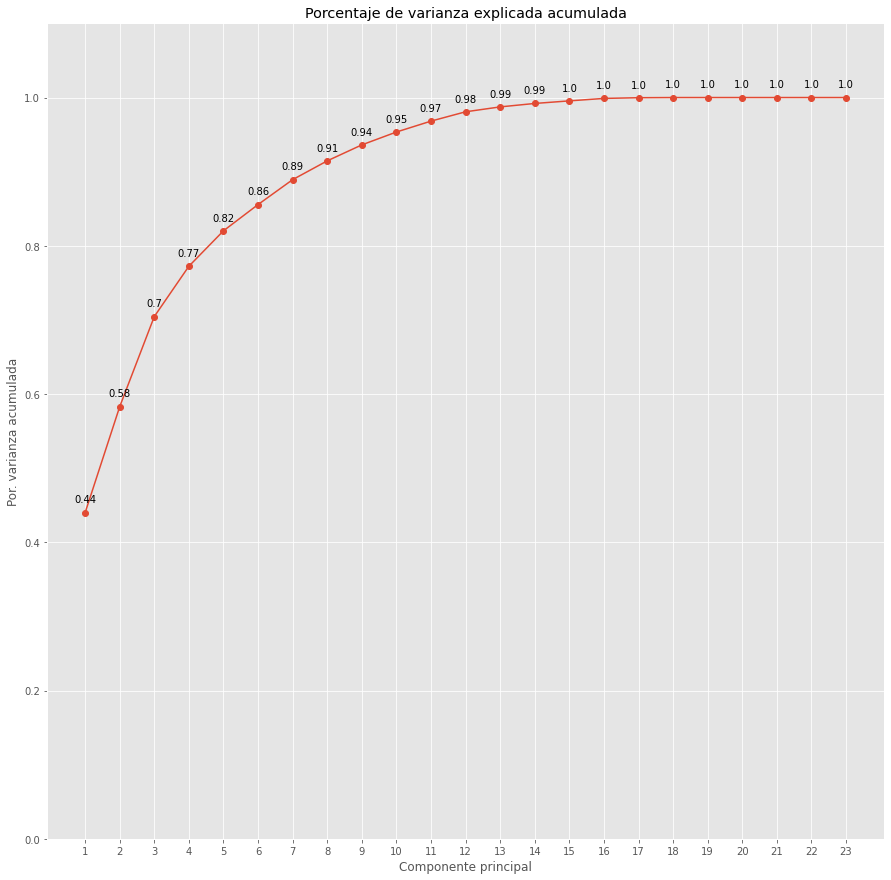

In [60]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.plot(
    np.arange(len(preprocessed_dataframe.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(preprocessed_dataframe.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [61]:
pca_pipe_robustScaler.fit(X)

preprocessed_dataframe = pd.DataFrame(preprocessor_robustScaler.fit_transform(X), columns=pca_pipe_robustScaler['preprocessor'].get_feature_names_out())
modelo_pca = pca_pipe_robustScaler.named_steps['pca']
len(modelo_pca.components_)

23

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[5.07183977e-01 1.10678694e-01 9.97087480e-02 5.86627225e-02
 4.52697729e-02 3.98112412e-02 3.22079340e-02 2.43623285e-02
 1.78431476e-02 1.60884235e-02 1.49475027e-02 1.18413404e-02
 6.55982481e-03 5.46601393e-03 4.34749066e-03 3.50752713e-03
 1.20032040e-03 3.03955267e-04 9.03606405e-06 1.79709924e-33
 9.88775872e-34 1.01068522e-34 8.31739180e-36]


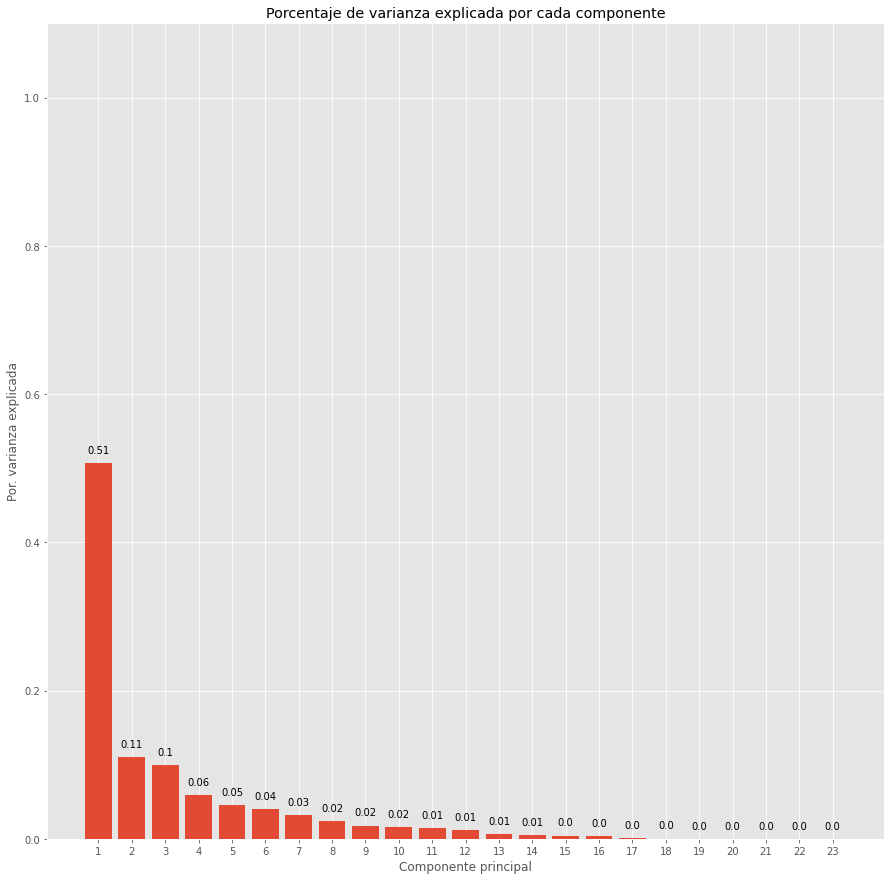

In [62]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(preprocessed_dataframe.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.50718398 0.61786267 0.71757142 0.77623414 0.82150391 0.86131516
 0.89352309 0.91788542 0.93572857 0.95181699 0.96676449 0.97860583
 0.98516566 0.99063167 0.99497916 0.99848669 0.99968701 0.99999096
 1.         1.         1.         1.         1.        ]


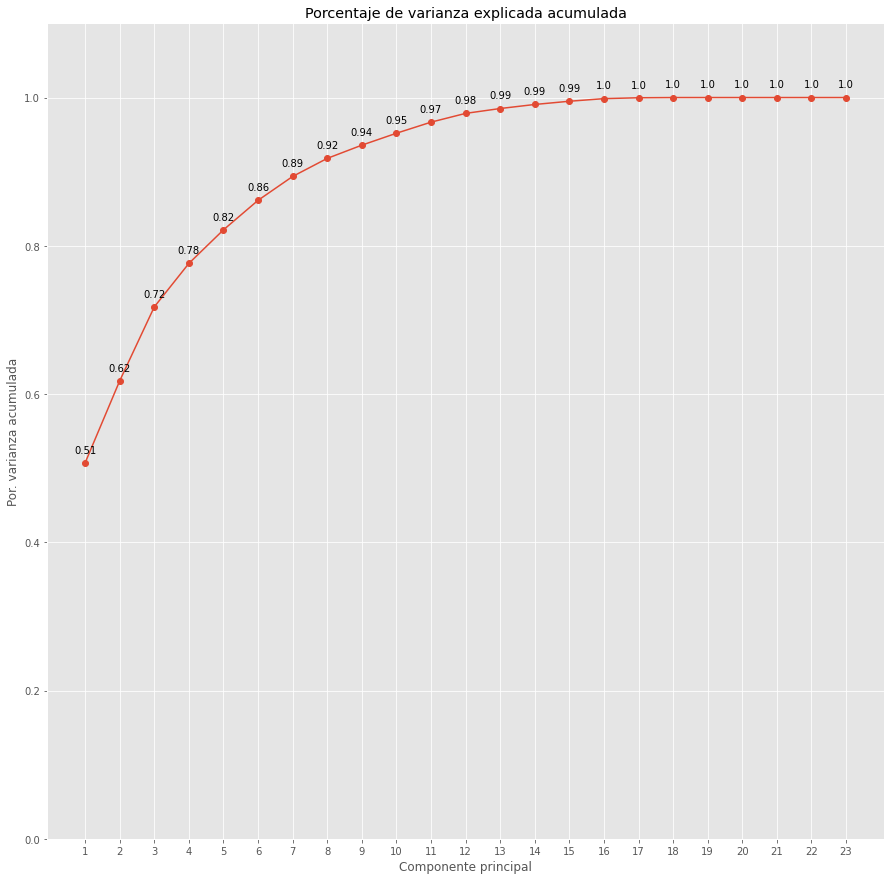

In [63]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.plot(
    np.arange(len(preprocessed_dataframe.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(preprocessed_dataframe.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');